<a href="https://colab.research.google.com/github/xamapro/msds19077_COVID19_DLSpring2020/blob/master/Usama_MSDS19077_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/Assignment 5 Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [0]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/content/Assignment 5 Dataset'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
def plot_loss_accuracy(train_accuracy, valid_accuracy, train_loss, valid_loss, plot_err=True):
  fig, f =  plt.subplots(1,2,figsize=(15,5))
  #plot accuracy curve
  f[0].plot(train_accuracy, label='Training Accuracy');
  if valid_accuracy:
      f[0].plot(valid_accuracy, label='Validation Accuracy');
  f[0].legend()
  
  f[0].set_xlabel('Epochs')
  f[0].set_ylabel('Accuracy')
  # plot error of the model if plot_err is true
  if plot_err == True:
      f[1].plot(train_loss, label='Train Loss');
      f[1].plot(valid_loss, label='Error for validation data', color='blue' )
      f[1].set_xlabel('Epochs')
      f[1].set_ylabel('Loss')
      f[1].legend()

In [0]:
def confusionMatrix(y, y_pred):
    matrix = np.zeros((2,2), dtype='int')
    for i, j in zip(y,y_pred):
        matrix[i.item()][j.item()]+=1
    return matrix

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, saveModelName = ''):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    trainConfMatrix = np.zeros((2,2))
    validConfMatrix = np.zeros((2,2))
    for epoch in range(num_epochs):
        tConfMatrix = np.zeros((2,2))
        vConfMatrix = np.zeros((2,2))
        start_time = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        #loss2 = criterion(aux_outputs, labels)
                        loss = loss1 #+ 0.4*loss2
                        _, tpreds = torch.max(outputs, 1)
                        # confusion matrix
                        tConfMatrix += confusionMatrix(labels, tpreds)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, vpreds = torch.max(outputs, 1)
                        vConfMatrix += confusionMatrix(labels, vpreds)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                train_loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                train_accuracy.append(epoch_acc)
                time_end = (time.time() - start_time)
                print('{} Loss: {:.4f} Acc: {:.4f} Execution Time {}'.format(phase, epoch_loss, epoch_acc, str(time_end // 60) + 'm ' + str(time_end % 60) + 's'))
            else:
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                valid_loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                valid_accuracy.append(epoch_acc)
                time_end = (time.time() - start_time)
                print('{} Loss: {:.4f} Acc: {:.4f} Execution Time {}'.format(phase, epoch_loss, epoch_acc, str(time_end // 60) + 'm ' + str(time_end % 60) + 's'))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()
        #print('\n \n {} Confusion Matrix \n {}'.format('Training', pd.DataFrame(tConfMatrix, columns=['infected', 'normal'], index=['infected', 'normal'])))
        #print('\n \n {} Confusion Matrix \n {}'.format('Vaidation', pd.DataFrame(vConfMatrix, columns=['infected', 'normal'], index=['infected', 'normal'])))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot_loss_accuracy(train_accuracy, valid_accuracy, train_loss, valid_loss, plot_err=True)
    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"/content/gdrive/My Drive/msds19077_COVID19_DLSpring2020/weights/{saveModelName}" 
    torch.save(model.state_dict(), path+'_entire.pth')
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs, (77*10)+100),
            nn.ReLU(inplace=True),
            nn.Linear((77*10)+100, num_classes)
            )
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = model_ft.classifier[6].in_features
        features = list(model_ft.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features,(77*10)+100), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear((77*10)+100, num_classes)])
        model_ft.classifier = nn.Sequential(*features)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [0]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
resnet18, input_size = initialize_model(model_name='resnet', num_classes=2, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
print(resnet18)

# Send the model to GPU
resnet18 = resnet18.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = resnet18.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training, validation and test datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}
# Create training, validation and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation', 'test']}



Initializing Datasets and Dataloaders...


Epoch 0/24
----------
train Loss: 0.3165 Acc: 0.8709 Execution Time 2.7215989351272585
validation Loss: 0.3460 Acc: 0.8487 Execution Time 3.075980325539907


 
 Training Confusion Matrix 
           infected  normal
infected    4051.0   868.0
normal       681.0  6400.0

 
 Vaidation Confusion Matrix 
           infected  normal
infected     511.0   104.0
normal       123.0   762.0
Epoch 1/24
----------
train Loss: 0.2995 Acc: 0.8792 Execution Time 2.73128236134847
validation Loss: 0.3513 Acc: 0.8513 Execution Time 3.069477919737498


 
 Training Confusion Matrix 
           infected  normal
infected    4131.0   788.0
normal       661.0  6420.0

 
 Vaidation Confusion Matrix 
           infected  normal
infected     533.0    82.0
normal       141.0   744.0
Epoch 2/24
----------
train Loss: 0.2941 Acc: 0.8777 Execution Time 2.7291688958803815
validation Loss: 0.3459 Acc: 0.8440 Execution Time 3.066143496831258


 
 Training Confusion Matrix 
           infected  normal
infected    4096.0

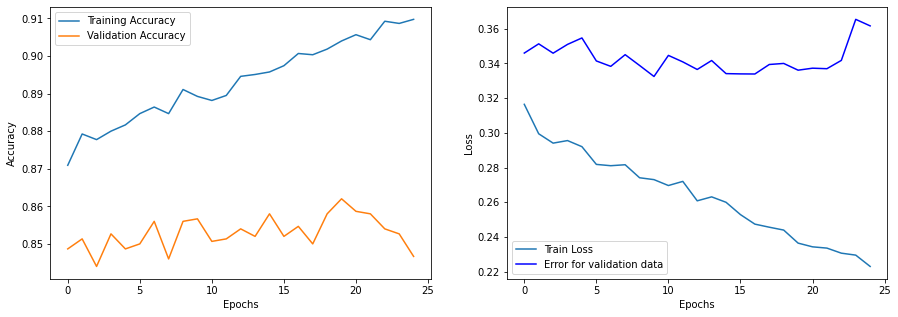

In [0]:

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
resnet18, hist = train_model(resnet18, dataloaders_dict, criterion, optimizer_ft, num_epochs=25, is_inception=(model_name=="resnet"), saveModelName='resnet18')

**Test Accuracy**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


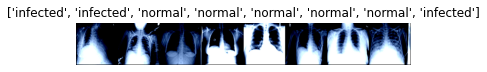

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

class_names = image_datasets['test'].classes

dataiter = iter(dataloaders_dict['train'])
images, labels = dataiter.next()
show_databatch(images[0:8], labels[0:8])
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)

In [0]:
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal normal infected normal infected infected infected normal infected infected normal infected infected normal normal normal normal normal infected normal normal infected infected normal normal infected normal normal normal
Ground Truth:  infected infected normal normal normal normal normal infected infected infected normal normal infected normal infected infected infected normal normal normal infected infected infected normal infected infected normal normal infected normal normal normal


In [0]:
correct = 0
total = 0
pred = np.zeros((2,2))
with torch.no_grad():
    for data in dataloaders_dict['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred += confusionMatrix(labels, predicted)

# F1 SCORE
tn, fp, fn, tp = pred.ravel()
recall = tp/(tp + fn)
precision = tp/((tp + fp))
f1_score = 2 * (recall * precision)/(precision + recall)
 
print('F1 Score: ', f1_score)

print('\n \n Test Confusion Matrix \n', pd.DataFrame(pred, columns=['normal', 'infected'], index=['normal', 'infected']))

print('\n \n Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Test Confusion Matrix 
           normal  infected
normal     540.0      75.0
infected    32.0     853.0

 
 Accuracy of the network on the 1500 test images: 92 %


**VGG 18**

In [0]:
# Initialize the model for this run
vgg16, input_size = initialize_model(model_name='vgg', num_classes=2, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
print(vgg16)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
vgg16 = vgg16.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = vgg16.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

Epoch 0/11
----------
train Loss: 0.3964 Acc: 0.8316 Execution Time 2.0m 47.00593590736389s
validation Loss: 0.3719 Acc: 0.8320 Execution Time 3.0m 8.223339557647705s

Epoch 1/11
----------
train Loss: 0.3613 Acc: 0.8550 Execution Time 2.0m 42.78244614601135s
validation Loss: 0.3503 Acc: 0.8460 Execution Time 3.0m 2.8055126667022705s

Epoch 2/11
----------
train Loss: 0.3561 Acc: 0.8553 Execution Time 2.0m 38.45645594596863s
validation Loss: 0.3558 Acc: 0.8527 Execution Time 2.0m 57.92088961601257s

Epoch 3/11
----------
train Loss: 0.3459 Acc: 0.8578 Execution Time 2.0m 30.28239941596985s
validation Loss: 0.3579 Acc: 0.8507 Execution Time 2.0m 49.00188946723938s

Epoch 4/11
----------
train Loss: 0.3410 Acc: 0.8567 Execution Time 2.0m 28.151877880096436s
validation Loss: 0.3448 Acc: 0.8507 Execution Time 2.0m 46.67146968841553s

Epoch 5/11
----------
train Loss: 0.3433 Acc: 0.8622 Execution Time 2.0m 27.72169542312622s
validation Loss: 0.3453 Acc: 0.8487 Execution Time 2.0m 46.1609616

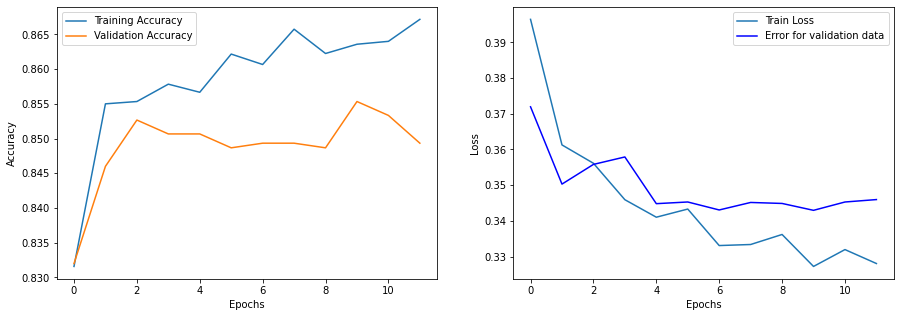

In [0]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
vgg16, hist = train_model(vgg16, dataloaders_dict, criterion, optimizer_ft, num_epochs=12, is_inception=(model_name=="vgg"), saveModelName='vgg16')

In [0]:
correct = 0
total = 0
pred = np.zeros((2,2))
with torch.no_grad():
    for data in dataloaders_dict['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred += confusionMatrix(labels, predicted)

# F1 SCORE
tn, fp, fn, tp = pred.ravel()
recall = tp/(tp + fn)
precision = tp/((tp + fp))
f1_score = 2 * (recall * precision)/(precision + recall)
 
print('F1 Score: ', f1_score)

print('\n \n Test Confusion Matrix \n', pd.DataFrame(pred, columns=['infected', 'normal'], index=['infected', 'normal']))

print('\n \n Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Test Confusion Matrix 
           infected  normal
infected     522.0    93.0
normal        34.0   851.0

 
 Accuracy of the network on the 1500 test images: 91 %


**TASK 2**

Resnet Experiment 2: unfreeze 4th convolution layers




In [21]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
resnet18_0, input_size = initialize_model(model_name='resnet', num_classes=2, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(resnet18_0)

# Send the model to GPU
resnet18_0 = resnet18_0.to(device)


ct = 0
for child in resnet18_0.children():
  ct += 1
  if ct in [9,8]:
      for param in child.parameters():
          param.requires_grad = False

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = resnet18_0.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18_0.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18_0.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/4
----------
train Loss: 0.2809 Acc: 0.8890 Execution Time 3.0m 13.348853349685669s
validation Loss: 0.3737 Acc: 0.8667 Execution Time 3.0m 37.20288896560669s

Epoch 1/4
----------
train Loss: 0.1989 Acc: 0.9267 Execution Time 3.0m 22.459815502166748s
validation Loss: 0.2399 Acc: 0.9087 Execution Time 3.0m 46.020429611206055s

Epoch 2/4
----------
train Loss: 0.1672 Acc: 0.9385 Execution Time 3.0m 20.88548231124878s
validation Loss: 0.4257 Acc: 0.8620 Execution Time 3.0m 44.320183992385864s

Epoch 3/4
----------
train Loss: 0.1463 Acc: 0.9448 Execution Time 3.0m 17.38151216506958s
validation Loss: 0.2657 Acc: 0.9060 Execution Time 3.0m 40.14031934738159s

Epoch 4/4
----------
train Loss: 0.1272 Acc: 0.9527 Execution Time 3.0m 15.488858222961426s
validation Loss: 0.2771 Acc: 0.8993 Execution Time 3.0m 38.28831481933594s

Training complete in 18m 26s
Best val Acc: 0.908667


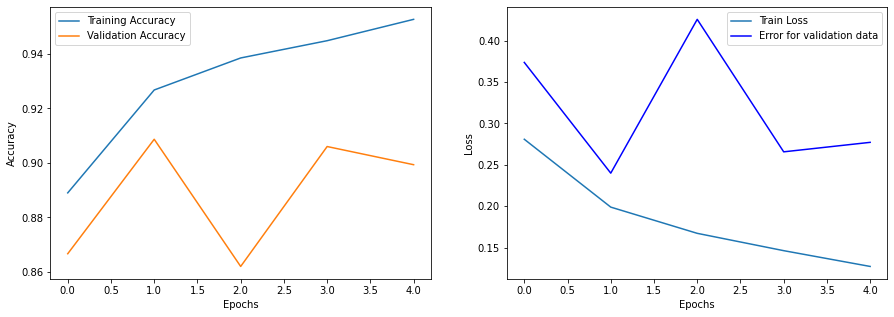

In [23]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
resnet18_0, hist = train_model(resnet18_0, dataloaders_dict, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="resnet"), saveModelName='resnet18')

In [31]:
train_pred = np.zeros((2,2))
valid_pred = np.zeros((2,2))
test_pred = np.zeros((2,2))

with torch.no_grad():
    # train
    correct = 0
    total = 0
    for data in dataloaders_dict['train']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_0(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = train_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Train Confusion Matrix \n', pd.DataFrame(train_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Train F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 12000 train images: %d %%' % (100 * correct / total))

    # validation
    correct = 0
    total = 0
    for data in dataloaders_dict['validation']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_0(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        valid_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = valid_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Validation Confusion Matrix \n', pd.DataFrame(valid_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Validation F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 1500 validation images: %d %%' % (100 * correct / total))

    # test
    correct = 0
    total = 0
    for data in dataloaders_dict['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_0(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = test_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Test Confusion Matrix \n', pd.DataFrame(test_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Test F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 1500 test images: %d %%' % (100 * correct / total))


 
 Train Confusion Matrix 
           infected  normal
infected    4580.0   339.0
normal       198.0  6883.0

 Train F1 Score:  0.9624554289309936

 
 Accuracy of the network on the 12000 train images: 95 %

 
 Validation Confusion Matrix 
           infected  normal
infected     538.0    77.0
normal        60.0   825.0

 Validation F1 Score:  0.9233351986569669

 
 Accuracy of the network on the 1500 validation images: 90 %

 
 Test Confusion Matrix 
           infected  normal
infected     580.0    35.0
normal        16.0   869.0

 Test F1 Score:  0.9714924538848518

 
 Accuracy of the network on the 1500 test images: 96 %


  Resnet Experiment 2: unfreeze 3rd, 4th convolution layers

In [16]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
resnet18_1, input_size = initialize_model(model_name='resnet', num_classes=2, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(resnet18_1)

# Send the model to GPU
resnet18_1 = resnet18_1.to(device)


ct = 0
for child in resnet18_1.children():
  ct += 1
  if ct in [9,8,7]:
      for param in child.parameters():
          param.requires_grad = False

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = resnet18_1.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18_1.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18_1.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/4
----------
train Loss: 0.3074 Acc: 0.8785 Execution Time 3.0m 15.942443132400513s
validation Loss: 0.3467 Acc: 0.8827 Execution Time 3.0m 38.77617168426514s

Epoch 1/4
----------
train Loss: 0.2385 Acc: 0.9110 Execution Time 3.0m 18.438368558883667s
validation Loss: 0.2626 Acc: 0.8947 Execution Time 3.0m 41.994715213775635s

Epoch 2/4
----------
train Loss: 0.2152 Acc: 0.9183 Execution Time 3.0m 19.207676649093628s
validation Loss: 0.2546 Acc: 0.9033 Execution Time 3.0m 42.3428418636322s

Epoch 3/4
----------
train Loss: 0.2017 Acc: 0.9254 Execution Time 3.0m 17.790133237838745s
validation Loss: 0.3527 Acc: 0.8913 Execution Time 3.0m 40.923502683639526s

Epoch 4/4
----------
train Loss: 0.1861 Acc: 0.9317 Execution Time 3.0m 16.24167776107788s
validation Loss: 0.2679 Acc: 0.8980 Execution Time 3.0m 39.33797836303711s

Training complete in 18m 23s
Best val Acc: 0.903333


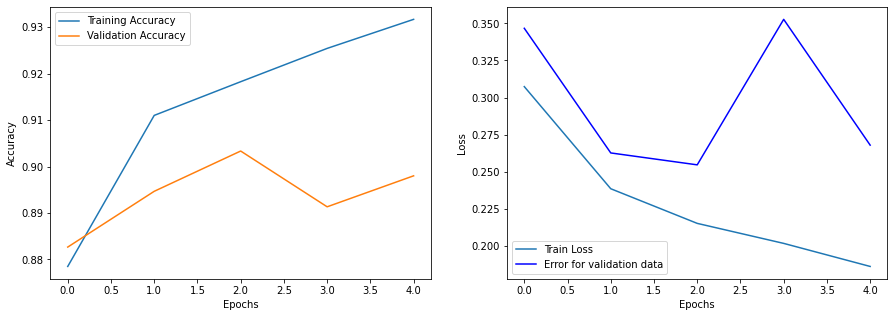

In [19]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
resnet18_1, hist = train_model(resnet18_1, dataloaders_dict, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="resnet"), saveModelName='resnet18')

In [33]:
train_pred = np.zeros((2,2))
valid_pred = np.zeros((2,2))
test_pred = np.zeros((2,2))

with torch.no_grad():
    # train
    correct = 0
    total = 0
    for data in dataloaders_dict['train']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = train_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Train Confusion Matrix \n', pd.DataFrame(train_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Train F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 12000 train images: %d %%' % (100 * correct / total))

    # validation
    correct = 0
    total = 0
    for data in dataloaders_dict['validation']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        valid_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = valid_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Validation Confusion Matrix \n', pd.DataFrame(valid_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Validation F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 1500 validation images: %d %%' % (100 * correct / total))

    # test
    correct = 0
    total = 0
    for data in dataloaders_dict['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = test_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Test Confusion Matrix \n', pd.DataFrame(test_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Test F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 1500 test images: %d %%' % (100 * correct / total))


 
 Train Confusion Matrix 
           infected  normal
infected    4493.0   426.0
normal       221.0  6860.0

 Train F1 Score:  0.9549662420825503

 
 Accuracy of the network on the 12000 train images: 94 %

 
 Validation Confusion Matrix 
           infected  normal
infected     529.0    86.0
normal        59.0   826.0

 Validation F1 Score:  0.9193099610461881

 
 Accuracy of the network on the 1500 validation images: 90 %

 
 Test Confusion Matrix 
           infected  normal
infected     578.0    37.0
normal        18.0   867.0

 Test F1 Score:  0.9692565679150363

 
 Accuracy of the network on the 1500 test images: 96 %


Resnet Experiment 3: unfreeze all convolution layers




In [10]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
resnet18_, input_size = initialize_model(model_name='resnet', num_classes=2, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(resnet18_)

# Send the model to GPU
resnet18_ = resnet18_.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = resnet18_.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18_.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18_.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Epoch 0/9
----------
train Loss: 0.2732 Acc: 0.8958 Execution Time 3.0m 29.933194160461426s
validation Loss: 0.2680 Acc: 0.8900 Execution Time 3.0m 53.60682773590088s

Epoch 1/9
----------
train Loss: 0.1911 Acc: 0.9297 Execution Time 3.0m 19.984680891036987s
validation Loss: 0.2273 Acc: 0.9100 Execution Time 3.0m 43.487947940826416s

Epoch 2/9
----------
train Loss: 0.1610 Acc: 0.9399 Execution Time 3.0m 20.827710151672363s
validation Loss: 0.2360 Acc: 0.9033 Execution Time 3.0m 44.05214738845825s

Epoch 3/9
----------
train Loss: 0.1305 Acc: 0.9494 Execution Time 3.0m 20.747047662734985s
validation Loss: 0.2340 Acc: 0.9160 Execution Time 3.0m 43.669772148132324s

Epoch 4/9
----------
train Loss: 0.1108 Acc: 0.9587 Execution Time 3.0m 17.789721727371216s
validation Loss: 0.2451 Acc: 0.9047 Execution Time 3.0m 40.53964614868164s

Epoch 5/9
----------
train Loss: 0.0920 Acc: 0.9647 Execution Time 3.0m 17.10482120513916s
validation Loss: 0.2458 Acc: 0.9133 Execution Time 3.0m 39.91244101

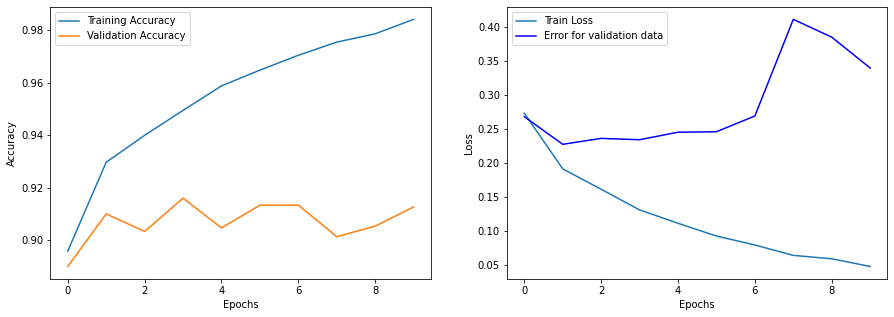

In [12]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
resnet18_, hist = train_model(resnet18_, dataloaders_dict, criterion, optimizer_ft, num_epochs=10, is_inception=(model_name=="resnet"), saveModelName='resnet18')

In [34]:
train_pred = np.zeros((2,2))
valid_pred = np.zeros((2,2))
test_pred = np.zeros((2,2))

with torch.no_grad():
    # train
    correct = 0
    total = 0
    for data in dataloaders_dict['train']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = train_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Train Confusion Matrix \n', pd.DataFrame(train_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Train F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 12000 train images: %d %%' % (100 * correct / total))

    # validation
    correct = 0
    total = 0
    for data in dataloaders_dict['validation']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        valid_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = valid_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Validation Confusion Matrix \n', pd.DataFrame(valid_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Validation F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 1500 validation images: %d %%' % (100 * correct / total))

    # test
    correct = 0
    total = 0
    for data in dataloaders_dict['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_pred += confusionMatrix(labels, predicted)
    # F1 SCORE
    tn, fp, fn, tp = test_pred.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)
    print('\n \n Test Confusion Matrix \n', pd.DataFrame(test_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
    print('\n Test F1 Score: ', f1_score)
    print('\n \n Accuracy of the network on the 1500 test images: %d %%' % (100 * correct / total))


 
 Train Confusion Matrix 
           infected  normal
infected    4460.0   459.0
normal        44.0  7037.0

 Train F1 Score:  0.965493585785827

 
 Accuracy of the network on the 12000 train images: 95 %

 
 Validation Confusion Matrix 
           infected  normal
infected     509.0   106.0
normal        34.0   851.0

 Validation F1 Score:  0.9239956568946797

 
 Accuracy of the network on the 1500 validation images: 90 %

 
 Test Confusion Matrix 
           infected  normal
infected     563.0    52.0
normal         6.0   879.0

 Test F1 Score:  0.9680616740088106

 
 Accuracy of the network on the 1500 test images: 96 %


vgg16 Experiment 1: unfreeze last convolution layers

In [0]:
def unfreeze_vgg16(model, num):
  num_features = 13
  count= num_features - num
  layer_num = 0
  for child in model.features.children():
    if (len(list(child.parameters()))>0):
      layer_num+=1
      if layer_num > count:
        for param in child.parameters():
          param.requires_grad = True

def accuracy_measures(model):
    train_pred = np.zeros((2,2))
    valid_pred = np.zeros((2,2))
    test_pred = np.zeros((2,2))

    with torch.no_grad():
        # train
        correct = 0
        total = 0
        for data in dataloaders_dict['train']:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_pred += confusionMatrix(labels, predicted)
        # F1 SCORE
        tn, fp, fn, tp = train_pred.ravel()
        recall = tp/(tp + fn)
        precision = tp/((tp + fp))
        f1_score = 2 * (recall * precision)/(precision + recall)
        print('\n \n Train Confusion Matrix \n', pd.DataFrame(train_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
        print('\n Train F1 Score: ', f1_score)
        print('\n \n Accuracy of the network on the 12000 train images: %d %%' % (100 * correct / total))

        # validation
        correct = 0
        total = 0
        for data in dataloaders_dict['validation']:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_pred += confusionMatrix(labels, predicted)
        # F1 SCORE
        tn, fp, fn, tp = valid_pred.ravel()
        recall = tp/(tp + fn)
        precision = tp/((tp + fp))
        f1_score = 2 * (recall * precision)/(precision + recall)
        print('\n \n Validation Confusion Matrix \n', pd.DataFrame(valid_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
        print('\n Validation F1 Score: ', f1_score)
        print('\n \n Accuracy of the network on the 1500 validation images: %d %%' % (100 * correct / total))

        # test
        correct = 0
        total = 0
        for data in dataloaders_dict['test']:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_pred += confusionMatrix(labels, predicted)
        # F1 SCORE
        tn, fp, fn, tp = test_pred.ravel()
        recall = tp/(tp + fn)
        precision = tp/((tp + fp))
        f1_score = 2 * (recall * precision)/(precision + recall)
        print('\n \n Test Confusion Matrix \n', pd.DataFrame(test_pred, columns=['infected', 'normal'], index=['infected', 'normal']))
        print('\n Test F1 Score: ', f1_score)
        print('\n \n Accuracy of the network on the 1500 test images: %d %%' % (100 * correct / total))

In [57]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
vgg16_0, input_size = initialize_model(model_name='vgg', num_classes=2, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
print(vgg16_0)

# Send the model to GPU
vgg16_0 = vgg16_0.to(device)

# unfreeze training for specific layer
unfreeze_vgg16(vgg16_0, 1)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = vgg16_0.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16_0.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg16_0.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 0/4
----------
train Loss: 0.2927 Acc: 0.8844 Execution Time 3.0m 19.795234203338623s
validation Loss: 0.2970 Acc: 0.8953 Execution Time 3.0m 44.13288164138794s

Epoch 1/4
----------
train Loss: 0.2266 Acc: 0.9131 Execution Time 3.0m 15.551599025726318s
validation Loss: 0.3351 Acc: 0.8353 Execution Time 3.0m 39.027047634124756s

Epoch 2/4
----------
train Loss: 0.1973 Acc: 0.9240 Execution Time 3.0m 14.269694089889526s
validation Loss: 0.2535 Acc: 0.8907 Execution Time 3.0m 38.193573236465454s

Epoch 3/4
----------
train Loss: 0.1817 Acc: 0.9301 Execution Time 3.0m 12.936141729354858s
validation Loss: 0.2657 Acc: 0.8987 Execution Time 3.0m 36.806883335113525s

Epoch 4/4
----------
train Loss: 0.1705 Acc: 0.9354 Execution Time 3.0m 14.654176473617554s
validation Loss: 0.2551 Acc: 0.8913 Execution Time 3.0m 38.79240012168884s

Training complete in 18m 17s
Best val Acc: 0.898667


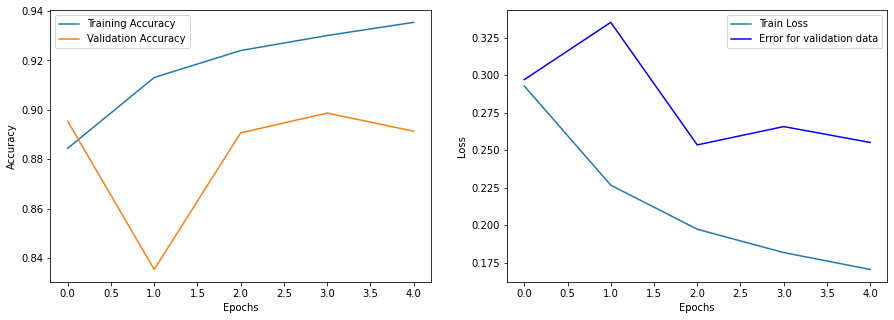

In [58]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
vgg16_0, hist = train_model(vgg16_0, dataloaders_dict, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="vgg"), saveModelName='vgg16_0')

In [61]:
accuracy_measures(vgg16_0)


 
 Train Confusion Matrix 
           infected  normal
infected    4404.0   515.0
normal       160.0  6921.0

 Train F1 Score:  0.95350278983261

 
 Accuracy of the network on the 12000 train images: 94 %

 
 Validation Confusion Matrix 
           infected  normal
infected     529.0    86.0
normal        66.0   819.0

 Validation F1 Score:  0.9150837988826815

 
 Accuracy of the network on the 1500 validation images: 89 %

 
 Test Confusion Matrix 
           infected  normal
infected     565.0    50.0
normal        15.0   870.0

 Test F1 Score:  0.96398891966759

 
 Accuracy of the network on the 1500 test images: 95 %


vgg16 Experiment 2: unfreeze last two convolution layers

In [63]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
vgg16_1, input_size = initialize_model(model_name='vgg', num_classes=2, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
print(vgg16_1)

# Send the model to GPU
vgg16_1 = vgg16_1.to(device)

# unfreeze training for specific layer
unfreeze_vgg16(vgg16_1, 3)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = vgg16_1.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16_1.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg16_1.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 0/4
----------
train Loss: 0.2608 Acc: 0.9038 Execution Time 3.0m 21.974409341812134s
validation Loss: 0.2548 Acc: 0.8873 Execution Time 3.0m 46.46377182006836s

Epoch 1/4
----------
train Loss: 0.1861 Acc: 0.9336 Execution Time 3.0m 18.059351205825806s
validation Loss: 0.2386 Acc: 0.9100 Execution Time 3.0m 41.72325253486633s

Epoch 2/4
----------
train Loss: 0.1562 Acc: 0.9450 Execution Time 3.0m 16.704110860824585s
validation Loss: 0.2653 Acc: 0.9060 Execution Time 3.0m 41.356738567352295s

Epoch 3/4
----------
train Loss: 0.1302 Acc: 0.9536 Execution Time 3.0m 17.244036197662354s
validation Loss: 0.2492 Acc: 0.9027 Execution Time 3.0m 41.457645654678345s

Epoch 4/4
----------
train Loss: 0.1133 Acc: 0.9580 Execution Time 3.0m 20.217221975326538s
validation Loss: 0.2220 Acc: 0.9113 Execution Time 3.0m 44.940478563308716s

Training complete in 18m 36s
Best val Acc: 0.911333


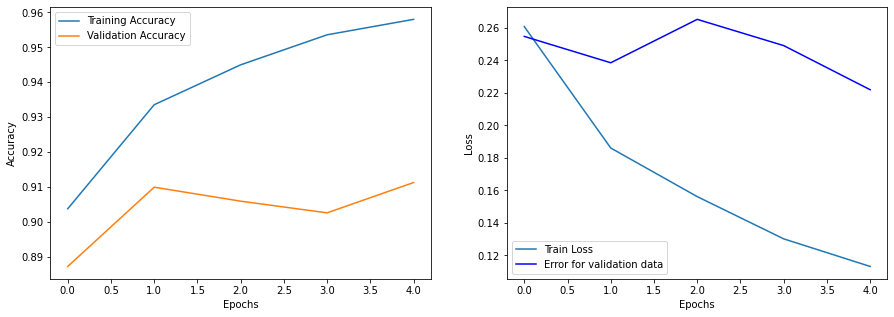

In [64]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
vgg16_1, hist = train_model(vgg16_1, dataloaders_dict, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="vgg"), saveModelName='vgg16_1')

In [65]:
accuracy_measures(vgg16_1)


 
 Train Confusion Matrix 
           infected  normal
infected    4641.0   278.0
normal        35.0  7046.0

 Train F1 Score:  0.9782714335300243

 
 Accuracy of the network on the 12000 train images: 97 %

 
 Validation Confusion Matrix 
           infected  normal
infected     538.0    77.0
normal        56.0   829.0

 Validation F1 Score:  0.9257398101619209

 
 Accuracy of the network on the 1500 validation images: 91 %

 
 Test Confusion Matrix 
           infected  normal
infected     572.0    43.0
normal         8.0   877.0

 Test F1 Score:  0.9717451523545707

 
 Accuracy of the network on the 1500 test images: 96 %


vgg16 Experiment 2: unfreeze all convolution layers

In [66]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
vgg16_, input_size = initialize_model(model_name='vgg', num_classes=2, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(vgg16_)

# Send the model to GPU
vgg16_ = vgg16_.to(device)


# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = vgg16_.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16_.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg16_.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 0/4
----------
train Loss: 0.6001 Acc: 0.6823 Execution Time 6.0m 9.583499908447266s
validation Loss: 0.3897 Acc: 0.8307 Execution Time 6.0m 34.111835956573486s

Epoch 1/4
----------
train Loss: 0.3115 Acc: 0.8831 Execution Time 6.0m 10.801101922988892s
validation Loss: 0.4213 Acc: 0.8180 Execution Time 6.0m 34.994765758514404s

Epoch 2/4
----------
train Loss: 0.2914 Acc: 0.8932 Execution Time 6.0m 8.219083309173584s
validation Loss: 0.2928 Acc: 0.8767 Execution Time 6.0m 33.688318729400635s

Epoch 3/4
----------
train Loss: 0.2285 Acc: 0.9151 Execution Time 6.0m 9.701307773590088s
validation Loss: 0.2590 Acc: 0.9013 Execution Time 6.0m 34.089540004730225s

Epoch 4/4
----------
train Loss: 0.2068 Acc: 0.9248 Execution Time 6.0m 9.452377557754517s
validation Loss: 0.2509 Acc: 0.9007 Execution Time 6.0m 33.637922525405884s

Training complete in 32m 51s
Best val Acc: 0.901333


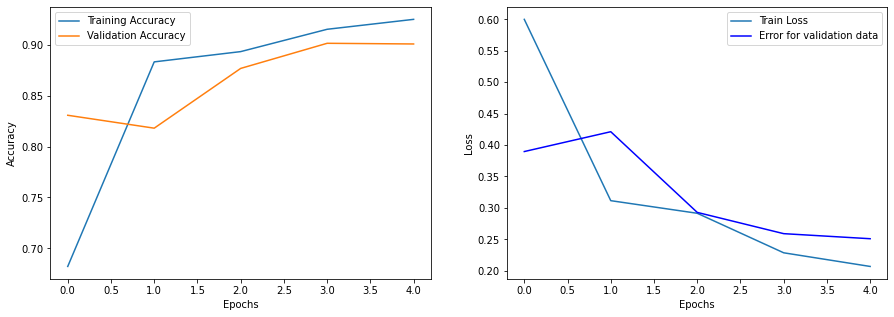

In [67]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
vgg16_, hist = train_model(vgg16_, dataloaders_dict, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="vgg"), saveModelName='vgg16_')

In [68]:
accuracy_measures(vgg16_)


 
 Train Confusion Matrix 
           infected  normal
infected    4354.0   565.0
normal       229.0  6852.0

 Train F1 Score:  0.9452338253552213

 
 Accuracy of the network on the 12000 train images: 93 %

 
 Validation Confusion Matrix 
           infected  normal
infected     518.0    97.0
normal        51.0   834.0

 Validation F1 Score:  0.9185022026431718

 
 Accuracy of the network on the 1500 validation images: 90 %

 
 Test Confusion Matrix 
           infected  normal
infected     556.0    59.0
normal        20.0   865.0

 Test F1 Score:  0.9563294637921504

 
 Accuracy of the network on the 1500 test images: 94 %
